In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


In [59]:
DATA_PATH = Path("laptop_data.csv")
assert DATA_PATH.exists(), f"{DATA_PATH} not found. Place the CSV next to the script."


In [60]:
df = pd.read_csv(DATA_PATH)

In [61]:
print(df.head())
print(df.info())
print("Duplicates:", df.duplicated().sum())
print("Nulls per column:\n", df.isnull().sum())

   Unnamed: 0 Company   TypeName  Inches                    ScreenResolution  \
0           0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1           1   Apple  Ultrabook    13.3                            1440x900   
2           2      HP   Notebook    15.6                   Full HD 1920x1080   
3           3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4           4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu   Ram               Memory  \
0        Intel Core i5 2.3GHz   8GB            128GB SSD   
1        Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz   8GB            256GB SSD   
3        Intel Core i7 2.7GHz  16GB            512GB SSD   
4        Intel Core i5 3.1GHz   8GB            256GB SSD   

                            Gpu  OpSys  Weight        Price  
0  Intel Iris Plus Graphics 640  macOS  1.37kg   71378.6832  
1        Intel HD Graphics 6000  m

In [62]:
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

In [63]:
df["Ram"]    = df["Ram"].str.replace("GB", "", regex=False).astype("int32")
df["Weight"] = df["Weight"].str.replace("kg", "", regex=False).astype("float32")

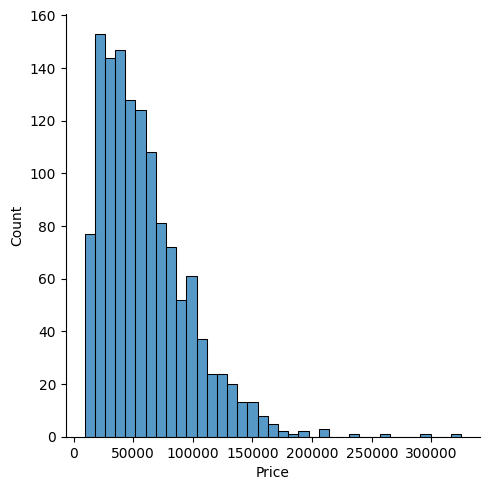

In [64]:
sns.displot(df["Price"])
plt.show()

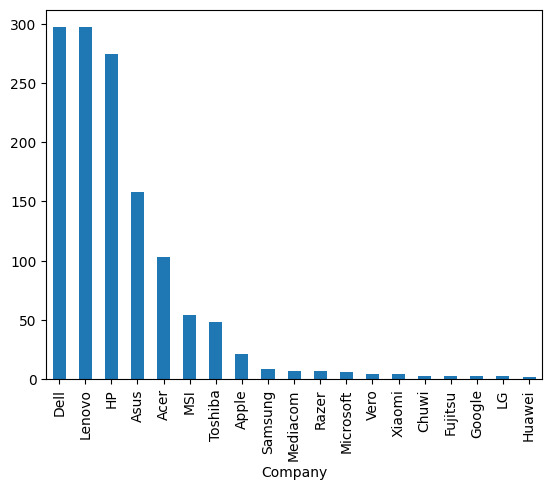

In [65]:
df["Company"].value_counts().plot(kind="bar")
plt.show()

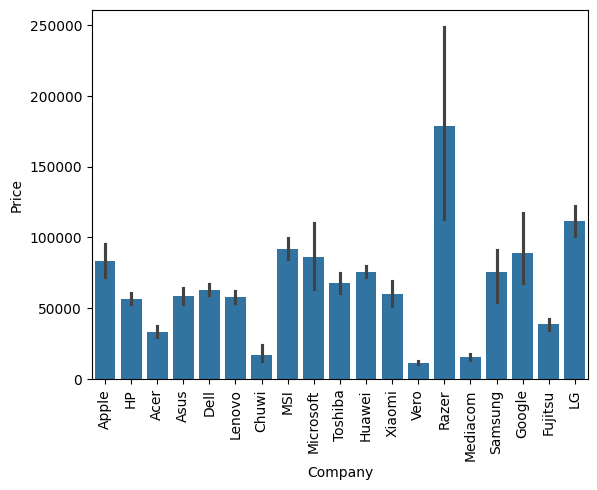

In [66]:
sns.barplot(x=df["Company"], y=df["Price"])
plt.xticks(rotation="vertical")
plt.show()

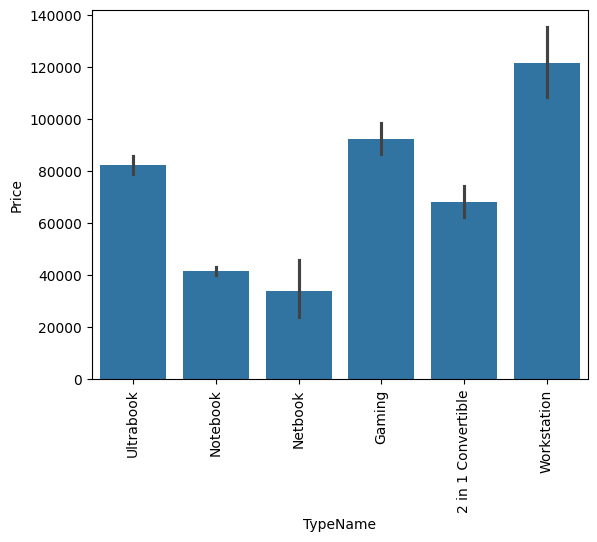

In [67]:
sns.barplot(x=df["TypeName"], y=df["Price"])
plt.xticks(rotation="vertical")
plt.show()

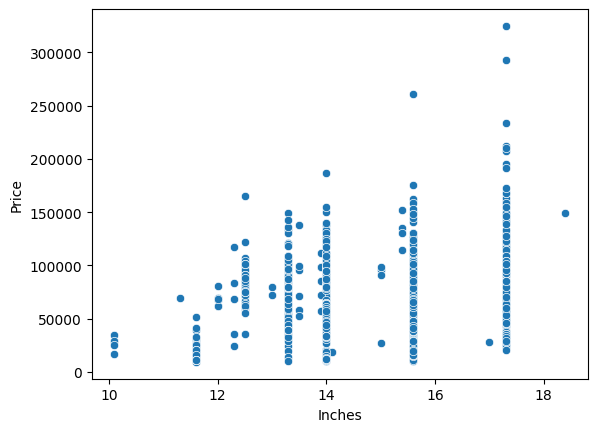

In [68]:
sns.scatterplot(x=df["Inches"], y=df["Price"])
plt.show()

In [69]:
df["Touchscreen"] = df["ScreenResolution"].apply(lambda x: 1 if "Touchscreen" in x else 0)
df["IPS"]         = df["ScreenResolution"].apply(lambda x: 1 if "IPS" in x else 0)


In [70]:
new_res = df["ScreenResolution"].str.split("x", n=1, expand=True)
df["X_res"] = new_res[0].str.replace(",", "").str.extract(r"(\d+)").astype(int)
df["Y_res"] = new_res[1].astype(int)
df["ppi"]   = (((df["X_res"]**2 + df["Y_res"]**2)**0.5) / df["Inches"]).astype(float)


In [71]:
df.drop(columns=["ScreenResolution", "Inches", "X_res", "Y_res"], inplace=True)

In [72]:
df["Cpu Name"] = df["Cpu"].apply(lambda x: " ".join(x.split()[0:3]))

In [73]:
def _cpu_brand(txt: str) -> str:
    if txt in {"Intel Core i7", "Intel Core i5", "Intel Core i3"}:
        return txt
    return "Other Intel Processor" if txt.split()[0] == "Intel" else "AMD Processor"


In [74]:
df["Cpu brand"] = df["Cpu Name"].apply(_cpu_brand)
df.drop(columns=["Cpu", "Cpu Name"], inplace=True)


In [75]:
df["Memory"] = df["Memory"].astype(str).str.replace("\.0", "", regex=True)
first_second = df["Memory"].str.split("+", n=1, expand=True)
df["first"]  = first_second[0].str.strip()
df["second"] = first_second[1].str.strip() if first_second.shape[1] > 1 else ""

df["second"] = df["second"].fillna("")


In [76]:
layer_map = {
    "Layer1HDD":  ("first",  "HDD"),
    "Layer1SSD":  ("first",  "SSD"),
    "Layer1Hybrid": ("first",  "Hybrid"),
    "Layer1Flash_Storage": ("first",  "Flash Storage"),
    "Layer2HDD":  ("second", "HDD"),
    "Layer2SSD":  ("second", "SSD"),
    "Layer2Hybrid": ("second", "Hybrid"),
    "Layer2Flash_Storage": ("second", "Flash Storage"),
}

In [77]:
for new_col, (src_col, key) in layer_map.items():
    df[new_col] = df[src_col].str.contains(key, case=False).astype(int)

In [78]:
def _to_gb(x: str) -> int:
    x = x.replace("GB", "").replace("TB", "000")
    digits = "".join(filter(str.isdigit, x))
    return int(digits) if digits else 0

In [79]:
df["first"]  = df["first"].apply(_to_gb)
df["second"] = df["second"].apply(_to_gb)

In [80]:
df["HDD"] = df["first"] * df["Layer1HDD"] + df["second"] * df["Layer2HDD"]
df["SSD"] = df["first"] * df["Layer1SSD"] + df["second"] * df["Layer2SSD"]

In [81]:
cols_to_drop = [
    "Memory", "first", "second",
    "Layer1HDD", "Layer1SSD", "Layer1Hybrid", "Layer1Flash_Storage",
    "Layer2HDD", "Layer2SSD", "Layer2Hybrid", "Layer2Flash_Storage",
]
df.drop(columns=cols_to_drop, inplace=True)

In [82]:
df["Gpu brand"] = df["Gpu"].str.split().str[0]
df.drop(columns=["Gpu"], inplace=True)

In [83]:
def _os_group(x: str) -> str:
    if x in {"Windows 10", "Windows 7", "Windows 10 S"}:
        return "Windows"
    if x in {"macOS", "Mac OS X"}:
        return "Mac"
    return "Others/No OS/Linux"

In [84]:
df["os"] = df["OpSys"].apply(_os_group)
df.drop(columns=["OpSys"], inplace=True)

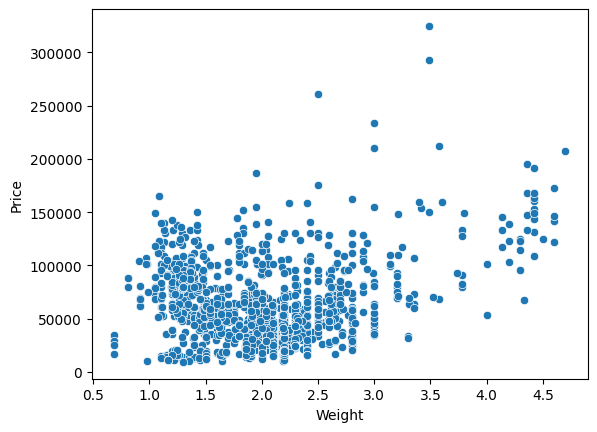

In [85]:
sns.scatterplot(x=df["Weight"], y=df["Price"])
plt.show()

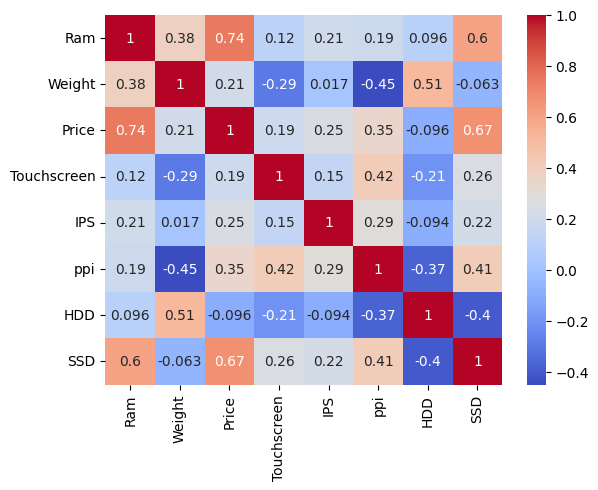

Shape after feature engineering: (1303, 13)


In [86]:
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.show()

print("Shape after feature engineering:", df.shape)


In [87]:
X = df.drop("Price", axis=1)
y = np.log(df["Price"])

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)

In [89]:
categorical_cols = ['Company', 'TypeName', 'Cpu brand', 'Gpu brand', 'os']
numeric_cols     = [c for c in X_train.columns if c not in categorical_cols]

In [90]:
numeric_trf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])

In [91]:
categorical_trf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", sparse_output=False))
])

In [92]:
preprocessor = ColumnTransformer([
    ("num", numeric_trf, numeric_cols),
    ("cat", categorical_trf, categorical_cols)
])

In [93]:
pipe = Pipeline([
    ("preprocessing", preprocessor),
    ("regressor", LinearRegression())
])

In [94]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Ram', 'Weight',
                                                   'Touchscreen', 'IPS', 'ppi',
                                                   'HDD', 'SSD']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Company', 'TypeName',
                                                   'Cpu brand', 'Gpu brand',
                                                   'os'])])),
                ('regressor', LinearRegression())])

In [95]:
y_pred = pipe.predict(X_test)
print(f"\n=== Evaluation ===")
print(f"R2  : {r2_score(y_test, y_pred):.3f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.3f}\n")



=== Evaluation ===
R2  : 0.820
MAE : 0.211



In [96]:
# If Unnamed: 0 is present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

In [97]:
with open("df.pkl", "wb") as f:
    pickle.dump(df, f)
with open("pipe.pkl", "wb") as f:
    pickle.dump(pipe, f)